# Q-SVM for Handwritten Digit Classification (MNIST dataset)

In [2]:
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from qiskit.circuit import QuantumCircuit, ParameterVector, ClassicalRegister, QuantumRegister
from qiskit import quantum_info

from qiskit_aer import AerSimulator
# from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService



# First iteration: 6 or 9 binary classification

## Dataset Reduction


In [2]:
# 1. Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=True)
mnist_df = mnist.frame               # DataFrame with pixels + “class” column
y = mnist_df['class'].astype(int)    # target
X = (mnist_df
    .drop(columns='class')
    .gt(230)                # pixel > 230 become True, else False
    .astype(np.int8))       # True → 1, False → 0   normalize pixel values to 0 and 1


# 2. Preprocess the data
# Need to just takes 6's and 9's from the dataset
mask = (y == 6) | (y == 9)
X_ds = X[mask]
y_ds = y[mask]


# Reduce to 4 principal components
pca = PCA(n_components=4 )
X_pca = pca.fit_transform(X_ds)

# Display the variance explained by each component
print(f"Variance explained by component: {pca.explained_variance_ratio_}")

# Split the dataset into training and testing sets
X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(X_pca, y_ds, test_size=0.2, random_state=0)

# smaller subset for training and testing
# for train subset:
X_train, _, y_train, _ = train_test_split(
    X_train_big, y_train_big,
    train_size=80,
    random_state=0,
    shuffle=True
)
# for test subset:
X_test, _, y_test, _ = train_test_split(
    X_test_big, y_test_big,
    train_size=20,
    random_state=0,
    shuffle=True
)

# Reset index of the training and testing sets
X_train = pd.DataFrame(X_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Set as 0 and 1 the target values
y_train = y_train.replace({6: 0, 9: 1})
y_test = y_test.replace({6: 0, 9: 1})

# Scale features to the range [0, 2*pi] - fit on training set only
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Display the first 5 rows of the filtered data
print(X_train.head())

# Print the shapes of the subsets
print(f"Subset shapes: X_train_subset: {X_train.shape}, y_train_subset: {y_train.shape}")
print(f"Subset shapes: X_test_subset: {X_test.shape}, y_test_subset: {y_test.shape}")



Variance explained by component: [0.0888468  0.06071838 0.05543229 0.03536443]
          0         1         2         3
0  2.744211  1.101778  2.432046  2.468882
1  0.481737  4.034049  2.113646  1.015023
2  2.151442  2.684588  0.552402  3.466373
3  3.510513  2.460263  1.745900  4.611677
4  2.305234  0.910501  1.259145  3.238771
Subset shapes: X_train_subset: (80, 4), y_train_subset: (80,)
Subset shapes: X_test_subset: (20, 4), y_test_subset: (20,)


#### Visualization of the "new" dataset

chosen the first 2 variables of the PCA

C:\Users\juanf\AppData\Local\Temp\ipykernel_32432\1223752163.py:15: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


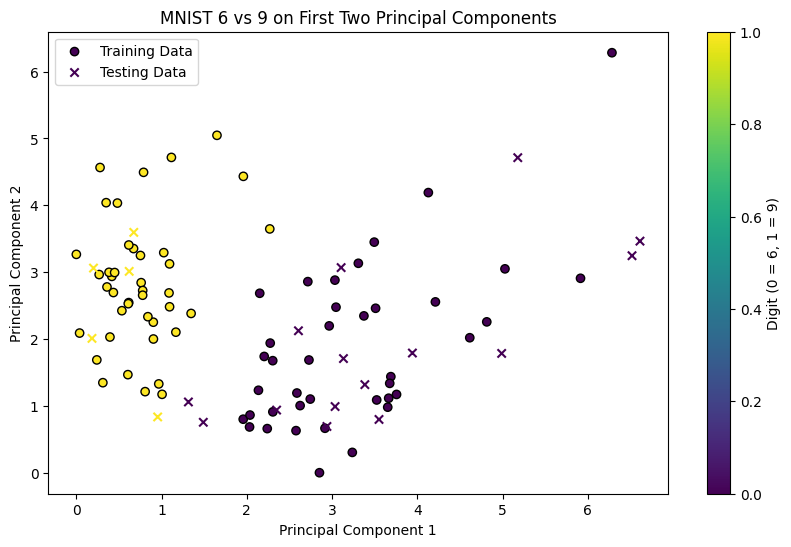

In [3]:
# 3. Visualize the data
plt.figure(figsize=(10, 6))

# Training data (PC1 vs PC2)
plt.scatter(
    X_train[0], X_train[1],
    c=y_train,
    cmap='viridis',
    marker='o',
    edgecolor='k',
    label='Training Data'
)

# Testing data (PC1 vs PC2)
plt.scatter(
    X_test[0], X_test[1],
    c=y_test,
    cmap='viridis',
    marker='x',
    edgecolor='k',
    label='Testing Data'
)

# Labels, colorbar and legend
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
cbar = plt.colorbar()
cbar.set_label("Digit (0 = 6, 1 = 9)")
plt.legend()
plt.title("MNIST 6 vs 9 on First Two Principal Components")
plt.show()


### Classical SVM in the MINST dataset   
For comparison purposes

In [4]:
# 3. Classical SVM Baseline Training

#Linear SVM
clf_linear = SVC(kernel='linear')
clf_linear.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf_linear.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.95


In [5]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.83      1.00      0.91         5

    accuracy                           0.95        20
   macro avg       0.92      0.97      0.94        20
weighted avg       0.96      0.95      0.95        20



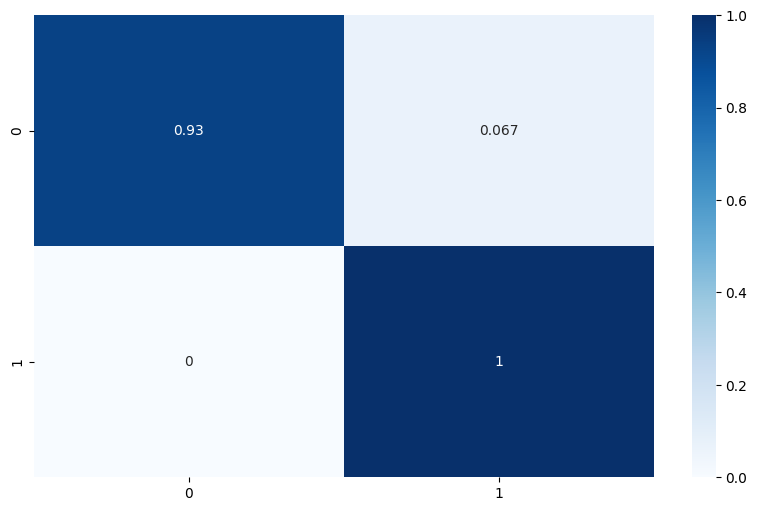

In [6]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(
	confusion_matrix(y_test, y_pred, normalize='true'),
	annot=True,
	cmap='Blues'
)
plt.show()

In [7]:
#RBF SVM
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf_linear.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.95


In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.83      1.00      0.91         5

    accuracy                           0.95        20
   macro avg       0.92      0.97      0.94        20
weighted avg       0.96      0.95      0.95        20



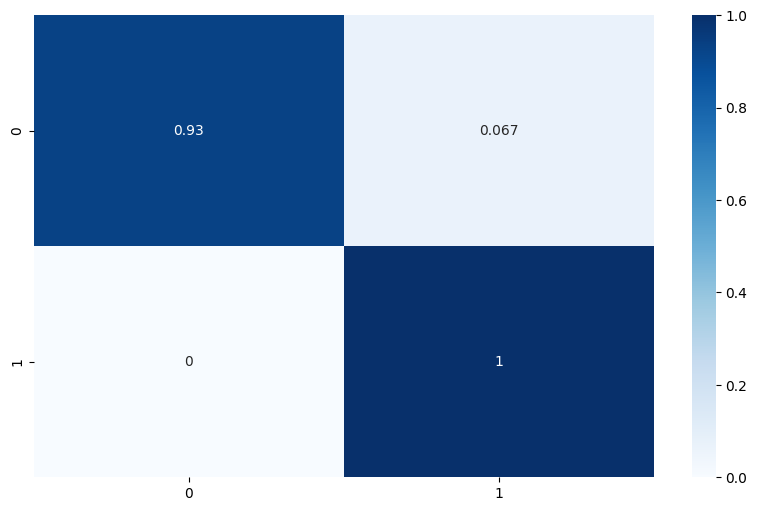

In [9]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(
	confusion_matrix(y_test, y_pred, normalize='true'),
	annot=True,
	cmap='Blues'
)
plt.show()

### Quantum Kernel

#### First iteration: simple feature map

In [10]:
n = 4
thetas = ParameterVector('θ',n)


qc = QuantumCircuit(n)

for i,t in enumerate(thetas):
    qc.ry(t, i)

for i in range(n-1):
    qc.cx(i, i+1)


qc.draw('mpl')
bound_circuit = qc

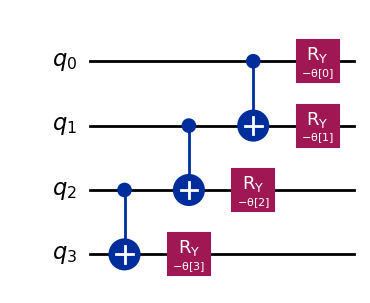

In [11]:
uncompute_circuit = qc.inverse()
uncompute_circuit.draw('mpl')

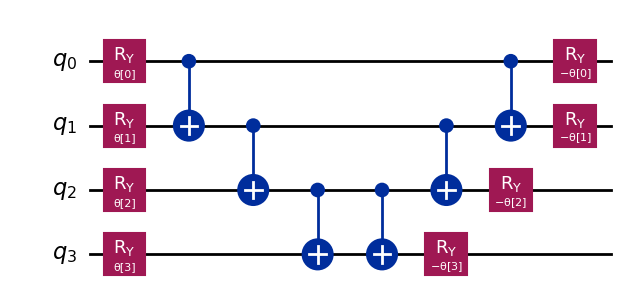

In [12]:
kernel_circuit_bound = QuantumCircuit(4)

kernel_circuit_bound.append(bound_circuit.to_instruction(), [0, 1, 2, 3])
kernel_circuit_bound.append(uncompute_circuit.to_instruction(), [0, 1, 2, 3])
kernel_circuit_bound.decompose().draw('mpl')

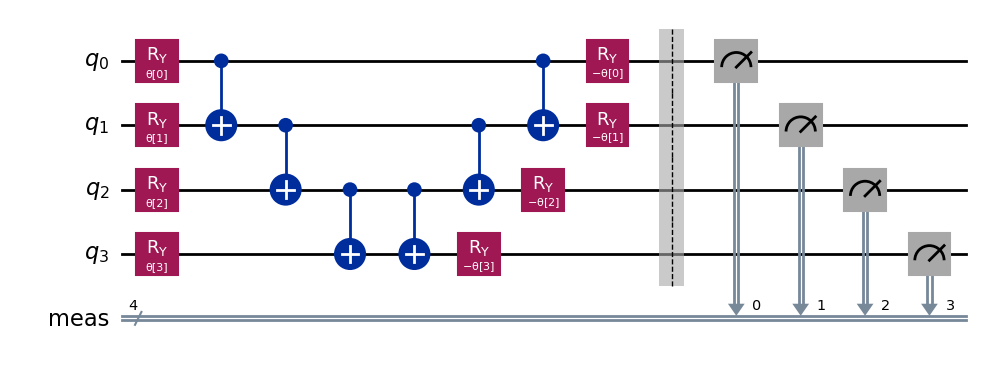

In [13]:
kernel_circuit_bound.measure_all()
kernel_circuit_bound.decompose().draw('mpl')

In [14]:
def quantum_kernel(x, y, sampler, n):
    
    kernel_circuit = QuantumCircuit(n)
    
    thetas = ParameterVector('θ',n)

    qc = QuantumCircuit(n)
    for i,t in enumerate(thetas):
        qc.ry(t, i)
    for i in range(n-1):
        qc.cx(i, i+1)
    bound_circuit = qc.assign_parameters(x)

    qc2 = QuantumCircuit(n)
    for i,t in enumerate(thetas):
        qc2.ry(t, i)
    for i in range(n-1):
        qc2.cx(i, i+1)
    uncompute_circuit = qc2.inverse().assign_parameters(y)
    
    kernel_circuit.append(bound_circuit.to_instruction(), [0, 1, 2, 3])
    kernel_circuit.append(uncompute_circuit.to_instruction(), [0, 1, 2, 3])
    
    kernel_circuit.measure_all()
    
    pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=1)
    isa_qc = pm.run(kernel_circuit)
    result = sampler.run([isa_qc]).result()
    pub_result = result[0]
    counts = pub_result.data.meas.get_counts()
    
    return counts['0000']/1024

In [ ]:
aer_sim = AerSimulator()
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_q = np.zeros((len(X_train), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_train)):
        print(i, "/", len(X_train))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_q[i, j] = quantum_kernel(X_train.iloc[i], X_train.iloc[j], sampler, n=4)
            except:
                K_q[i, j] = 0

# Print the kernel matrix
print(K_q)

0 / 80
1 / 80
2 / 80
3 / 80
4 / 80
5 / 80
6 / 80
7 / 80
8 / 80
9 / 80
10 / 80
11 / 80
12 / 80
13 / 80
14 / 80
15 / 80
16 / 80
17 / 80
18 / 80
19 / 80
20 / 80
21 / 80
22 / 80
23 / 80
24 / 80
25 / 80
26 / 80
27 / 80
28 / 80
29 / 80
30 / 80
31 / 80
32 / 80
33 / 80
34 / 80
35 / 80
36 / 80
37 / 80
38 / 80
39 / 80
40 / 80
41 / 80
42 / 80
43 / 80
44 / 80
45 / 80
46 / 80
47 / 80
48 / 80
49 / 80
50 / 80
51 / 80
52 / 80
53 / 80
54 / 80
55 / 80
56 / 80
57 / 80
58 / 80
59 / 80
60 / 80
61 / 80
62 / 80
63 / 80
64 / 80
65 / 80
66 / 80
67 / 80
68 / 80
69 / 80
70 / 80
71 / 80
72 / 80
73 / 80
74 / 80
75 / 80
76 / 80
77 / 80
78 / 80
79 / 80
[[1.00000000e+00 9.76562500e-04 1.26953125e-01 ... 7.53906250e-01
  6.32812500e-01 1.17187500e-02]
 [1.95312500e-03 1.00000000e+00 1.75781250e-02 ... 2.92968750e-03
  0.00000000e+00 5.95703125e-02]
 [1.00585938e-01 1.17187500e-02 1.00000000e+00 ... 1.52343750e-01
  3.90625000e-03 2.83203125e-02]
 ...
 [7.88085938e-01 4.88281250e-03 1.39648438e-01 ... 1.00000000e+00
  

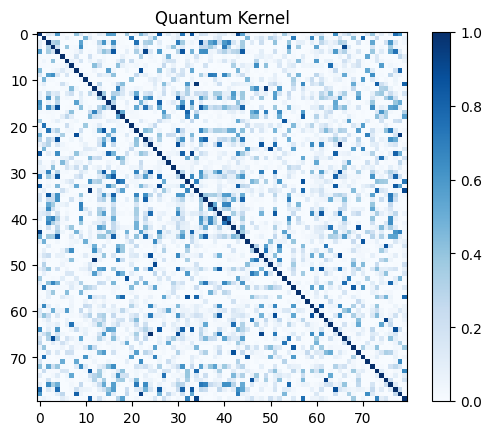

In [16]:
# Plot the kernel matrix as a heatmap
plt.imshow(K_q, cmap="Blues")
plt.title("Quantum Kernel")
plt.colorbar()
plt.show()

In [17]:
clf = SVC(gamma='auto', kernel='precomputed')
clf.fit(K_q, y_train)

SVC(gamma='auto', kernel='precomputed')

In [ ]:
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_test = np.zeros((len(X_test), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_test)):
        print(i, "/", len(X_test))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_test[i, j] = quantum_kernel(X_test.iloc[i], X_train.iloc[j], sampler, n=4)
            except:
                K_test[i, j] = 0


0 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20


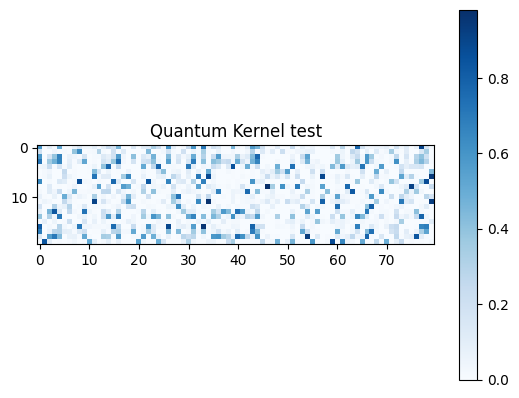

In [19]:
# Plot the kernel matrix as a heatmap
plt.imshow(K_test, cmap="Blues")
plt.title("Quantum Kernel test")
plt.colorbar()
plt.show()

In [20]:
y_pred_q = clf.predict(K_test)
# Calculate accuracy
accuracy_q = accuracy_score(y_test, y_pred_q)
print('Accuracy:', accuracy_q)

Accuracy: 0.9


In [21]:
accuracy_score(y_pred, y_pred_q)

0.85

In [22]:
print(classification_report(y_test, y_pred_q))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.71      1.00      0.83         5

    accuracy                           0.90        20
   macro avg       0.86      0.93      0.88        20
weighted avg       0.93      0.90      0.90        20



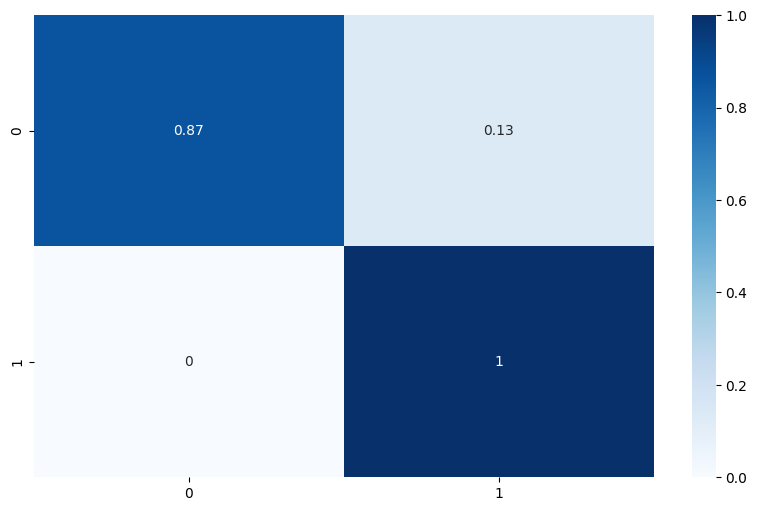

In [23]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_q, normalize='true'),annot=True,cmap='Blues')
plt.show() 

### Second iteration. separation between digits 1 & 7 (they are more similar)

In [2]:
# 1. Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=True)
mnist_df = mnist.frame               # DataFrame with pixels + “class” column
y = mnist_df['class'].astype(int)    # target
X = (mnist_df
    .drop(columns='class')
    .gt(230)                # pixel > 230 become True, else False
    .astype(np.int8))       # True → 1, False → 0   normalize pixel values to 0 and 1


# 2. Preprocess the data
# Need to just takes 1's and 7's from the dataset
mask = (y == 6) | (y == 9)
X_ds = X[mask]
y_ds = y[mask]


# Reduce to 8 principal components
pca = PCA(n_components=4 )
X_pca = pca.fit_transform(X_ds)

# Display the variance explained by each component
print(f"Variance explained by component: {pca.explained_variance_ratio_}")

# Split the dataset into training and testing sets
X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(X_pca, y_ds, test_size=0.2, random_state=0)

# smaller subset for training and testing
# for train subset:
X_train, _, y_train, _ = train_test_split(
    X_train_big, y_train_big,
    train_size=80,
    random_state=0,
    shuffle=True
)
# for test subset:
X_test, _, y_test, _ = train_test_split(
    X_test_big, y_test_big,
    train_size=20,
    random_state=0,
    shuffle=True
)

# Reset index of the training and testing sets
X_train = pd.DataFrame(X_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Set as 0 and 1 the target values
y_train = y_train.replace({6: 0, 9: 1})
y_test = y_test.replace({6: 0, 9: 1})

# Scale features to the range [0, 2*pi] - fit on training set only
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Display the first 5 rows of the filtered data
print(X_train.head())

# Print the shapes of the subsets
print(f"Subset shapes: X_train_subset: {X_train.shape}, y_train_subset: {y_train.shape}")
print(f"Subset shapes: X_test_subset: {X_test.shape}, y_test_subset: {y_test.shape}")



Variance explained by component: [0.0888468  0.06071838 0.05543229 0.03536443]
          0         1         2         3
0  2.744211  1.101778  2.432046  2.468882
1  0.481737  4.034049  2.113646  1.015023
2  2.151442  2.684588  0.552402  3.466373
3  3.510513  2.460263  1.745900  4.611677
4  2.305234  0.910501  1.259145  3.238771
Subset shapes: X_train_subset: (80, 4), y_train_subset: (80,)
Subset shapes: X_test_subset: (20, 4), y_test_subset: (20,)


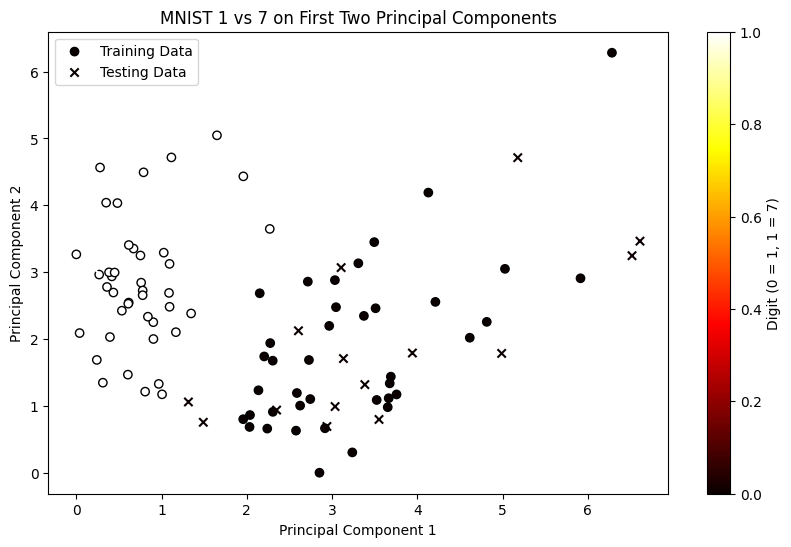

In [ ]:
# 3. Visualize the data
plt.figure(figsize=(10, 6))

# Training data (PC1 vs PC2)
plt.scatter(
    X_train[0], X_train[1],
    c=y_train,
    cmap='hot',
    marker='o',
    edgecolor='k',
    label='Training Data'
)

# Testing data (PC1 vs PC2)
plt.scatter(
    X_test[0], X_test[1],
    c=y_test,
    cmap='hot',
    marker='x',
    label='Testing Data'
)

# Labels, colorbar and legend
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
cbar = plt.colorbar()
cbar.set_label("Digit (0 = 1, 1 = 7)")
plt.legend()
plt.title("MNIST 1 vs 7 on First Two Principal Components")
plt.show()


### Classical SVM

In [4]:
# 3. Classical SVM Baseline Training

#Linear SVM
clf_linear = SVC(kernel='linear')
clf_linear.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf_linear.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.95


In [5]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.83      1.00      0.91         5

    accuracy                           0.95        20
   macro avg       0.92      0.97      0.94        20
weighted avg       0.96      0.95      0.95        20



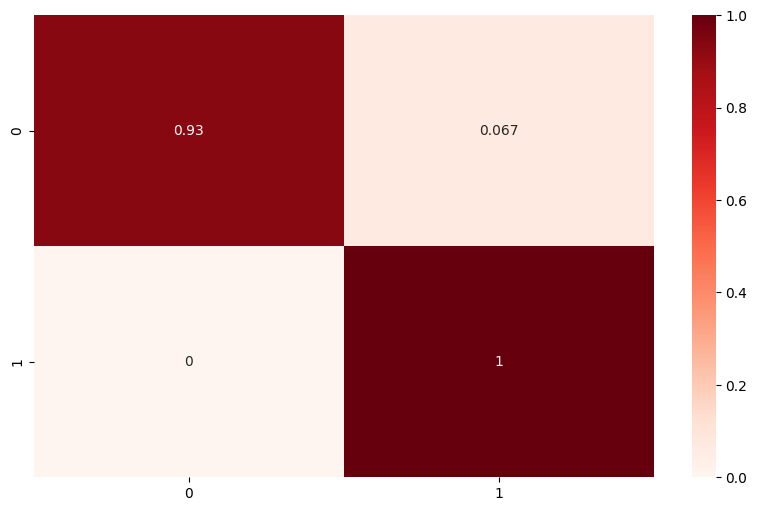

In [6]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(
	confusion_matrix(y_test, y_pred, normalize='true'),
	annot=True,
	cmap='Reds'
)
plt.show()

### Quantum Kernel

In [7]:
def quantum_kernel(x, y, sampler, n):
    
    kernel_circuit = QuantumCircuit(n)
    
    thetas = ParameterVector('θ',n)

    qc = QuantumCircuit(n)
    for i,t in enumerate(thetas):
        qc.ry(t, i)
    for i in range(n-1):
        qc.cx(i, i+1)
    bound_circuit = qc.assign_parameters(x)

    qc2 = QuantumCircuit(n)
    for i,t in enumerate(thetas):
        qc2.ry(t, i)
    for i in range(n-1):
        qc2.cx(i, i+1)
    uncompute_circuit = qc2.inverse().assign_parameters(y)
    
    kernel_circuit.append(bound_circuit.to_instruction(), [0, 1, 2, 3])
    kernel_circuit.append(uncompute_circuit.to_instruction(), [0, 1, 2, 3])
    
    kernel_circuit.measure_all()
    
    pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=1)
    isa_qc = pm.run(kernel_circuit)
    result = sampler.run([isa_qc]).result()
    pub_result = result[0]
    counts = pub_result.data.meas.get_counts()
    
    return counts['0000']/1024


In [ ]:
aer_sim = AerSimulator()
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_q = np.zeros((len(X_train), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_train)):
        print(i, "/", len(X_train))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_q[i, j] = quantum_kernel(X_train.iloc[i], X_train.iloc[j], sampler, n=4)
            except:
                K_q[i, j] = 0

# Print the kernel matrix
print(K_q)

0 / 80
1 / 80
2 / 80
3 / 80
4 / 80
5 / 80
6 / 80
7 / 80
8 / 80
9 / 80
10 / 80
11 / 80
12 / 80
13 / 80
14 / 80
15 / 80
16 / 80
17 / 80
18 / 80
19 / 80
20 / 80
21 / 80
22 / 80
23 / 80
24 / 80
25 / 80
26 / 80
27 / 80
28 / 80
29 / 80
30 / 80
31 / 80
32 / 80
33 / 80
34 / 80
35 / 80
36 / 80
37 / 80
38 / 80
39 / 80
40 / 80
41 / 80
42 / 80
43 / 80
44 / 80
45 / 80
46 / 80
47 / 80
48 / 80
49 / 80
50 / 80
51 / 80
52 / 80
53 / 80
54 / 80
55 / 80
56 / 80
57 / 80
58 / 80
59 / 80
60 / 80
61 / 80
62 / 80
63 / 80
64 / 80
65 / 80
66 / 80
67 / 80
68 / 80
69 / 80
70 / 80
71 / 80
72 / 80
73 / 80
74 / 80
75 / 80
76 / 80
77 / 80
78 / 80
79 / 80
[[1.00000000e+00 3.90625000e-03 1.25000000e-01 ... 7.62695312e-01
  6.25000000e-01 1.36718750e-02]
 [9.76562500e-04 1.00000000e+00 1.46484375e-02 ... 2.92968750e-03
  0.00000000e+00 5.07812500e-02]
 [1.23046875e-01 2.53906250e-02 1.00000000e+00 ... 1.38671875e-01
  3.90625000e-03 2.92968750e-02]
 ...
 [7.79296875e-01 9.76562500e-04 1.23046875e-01 ... 1.00000000e+00
  

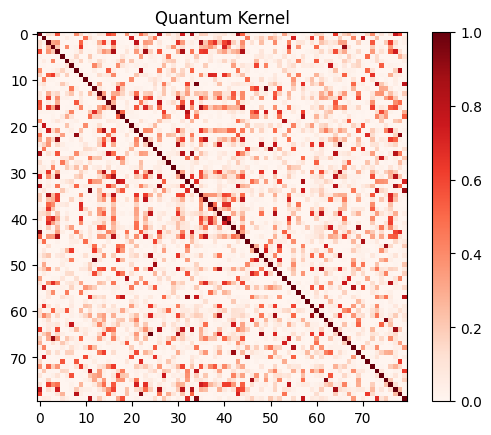

In [9]:
# Plot the kernel matrix as a heatmap
plt.imshow(K_q, cmap="Reds")
plt.title("Quantum Kernel")
plt.colorbar()
plt.show()

In [10]:
clf = SVC(gamma='auto', kernel='precomputed')
clf.fit(K_q, y_train)

SVC(gamma='auto', kernel='precomputed')

In [ ]:
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_test = np.zeros((len(X_test), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_test)):
        print(i, "/", len(X_test))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_test[i, j] = quantum_kernel(X_test.iloc[i], X_train.iloc[j], sampler, n=4)
            except:
                K_test[i, j] = 0


0 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20


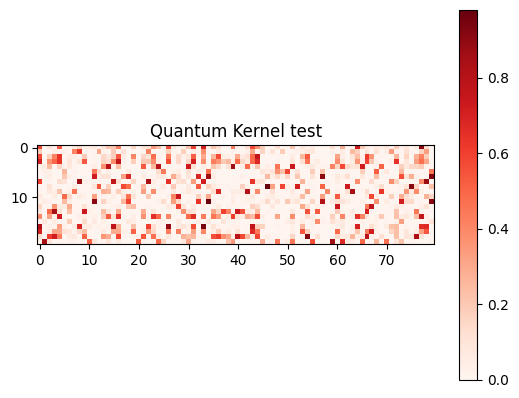

In [12]:
# Plot the kernel matrix as a heatmap
plt.imshow(K_test, cmap="Reds")
plt.title("Quantum Kernel test")
plt.colorbar()
plt.show()

In [13]:
y_pred_q = clf.predict(K_test)
# Calculate accuracy
accuracy_q = accuracy_score(y_test, y_pred_q)
print('Accuracy:', accuracy_q)

Accuracy: 0.9


In [14]:
accuracy_score(y_pred, y_pred_q)

0.85

In [15]:
print(classification_report(y_test, y_pred_q))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.71      1.00      0.83         5

    accuracy                           0.90        20
   macro avg       0.86      0.93      0.88        20
weighted avg       0.93      0.90      0.90        20



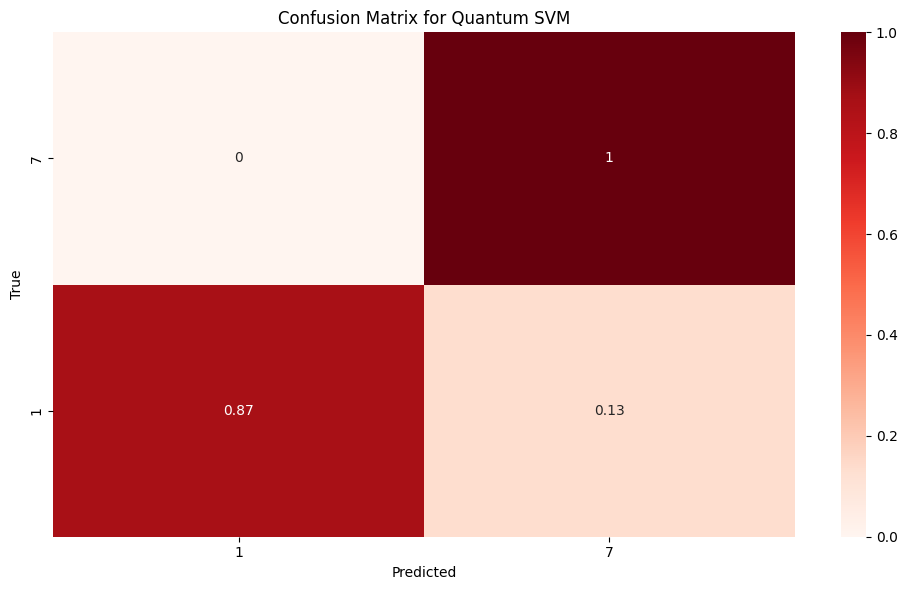

In [16]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_q, normalize='true'),annot=True,cmap='Reds')
# add lables to show what is what
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Quantum SVM")
plt.xticks(ticks=[0.5, 1.5], labels=["1", "7"])
plt.yticks(ticks=[0.5, 1.5], labels=["1", "7"])
plt.gca().invert_yaxis()  # Invert y-axis to match the usual confusion matrix orientation
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show() 
#

trying to improve this solution with another feature map

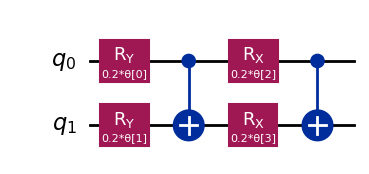

In [17]:
n = 2
thetas = ParameterVector('θ',X_train.shape[1])
alpha = 0.2

qc = QuantumCircuit(n)

qc.ry(thetas[0] * alpha, 0)
qc.ry(thetas[1] * alpha, 1)

for i in range(n-1):
    qc.cx(i, i+1)

qc.rx(thetas[2] * alpha, 0)
qc.rx(thetas[3] * alpha, 1)

for i in range(n-1):
    qc.cx(i, i+1)


qc.draw('mpl')

In [18]:
def quantum_kernel(x, y, sampler, n):

    # Compute the kernel value
    
    kernel_circuit = QuantumCircuit(n)

    bound_circuit = qc.assign_parameters(x[:X.shape[1]])
    uncompute_circuit = qc.inverse().assign_parameters(y[:X.shape[1]])
    
    kernel_circuit.append(bound_circuit.to_instruction(), [i for i in range(n)])
    kernel_circuit.append(uncompute_circuit.to_instruction(), [i for i in range(n)])
    kernel_circuit.measure_all()

    pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=1)
    isa_qc = pm.run(kernel_circuit)
    result = sampler.run([isa_qc]).result()
    pub_result = result[0]
    counts = pub_result.data.meas.get_counts()
    return counts['0'*n]/1024




In [ ]:
aer_sim = AerSimulator()
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_q = np.zeros((len(X_train), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_train)):
        print(i, "/", len(X_train))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_q[i, j] = quantum_kernel(X_train.iloc[i], X_train.iloc[j], sampler, n=2)
            except:
                K_q[i, j] = 0

# Print the kernel matrix
print(K_q)

0 / 80
1 / 80
2 / 80
3 / 80
4 / 80
5 / 80
6 / 80
7 / 80
8 / 80
9 / 80
10 / 80


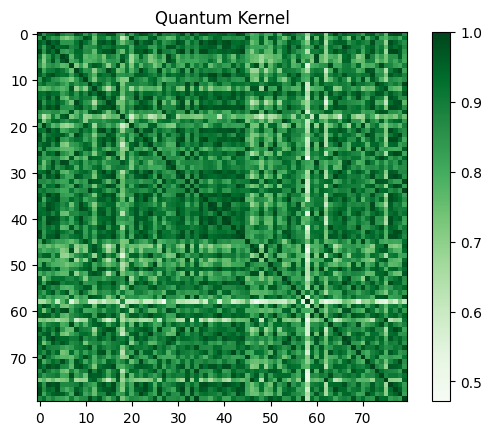

In [ ]:
# Plot the kernel matrix as a heatmap
plt.imshow(K_q, cmap="Greens")
plt.title("Quantum Kernel")
plt.colorbar()
plt.show()

In [ ]:
clf = SVC(gamma='auto', kernel='precomputed')
clf.fit(K_q, y_train)

SVC(gamma='auto', kernel='precomputed')

In [ ]:
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_test = np.zeros((len(X_test), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_test)):
        print(i, "/", len(X_test))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_test[i, j] = quantum_kernel(X_test.iloc[i], X_train.iloc[j], sampler, n=2)
            except:
                K_test[i, j] = 0


0 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20


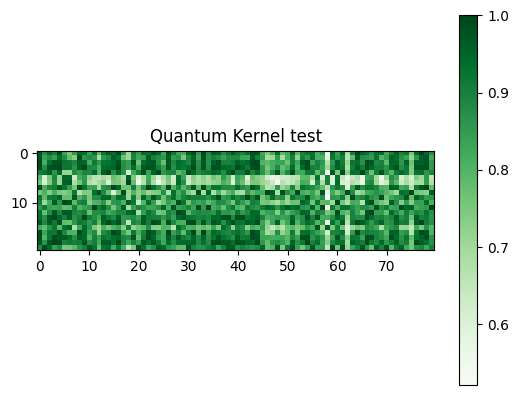

In [ ]:
# Plot the kernel matrix as a heatmap
plt.imshow(K_test, cmap="Greens")
plt.title("Quantum Kernel test")
plt.colorbar()
plt.show()

In [ ]:
y_pred_q = clf.predict(K_test)
# Calculate accuracy
accuracy_q = accuracy_score(y_test, y_pred_q)
print('Accuracy:', accuracy_q)

Accuracy: 1.0


In [ ]:
accuracy_score(y_pred, y_pred_q)

0.95

In [ ]:
print(classification_report(y_test, y_pred_q))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



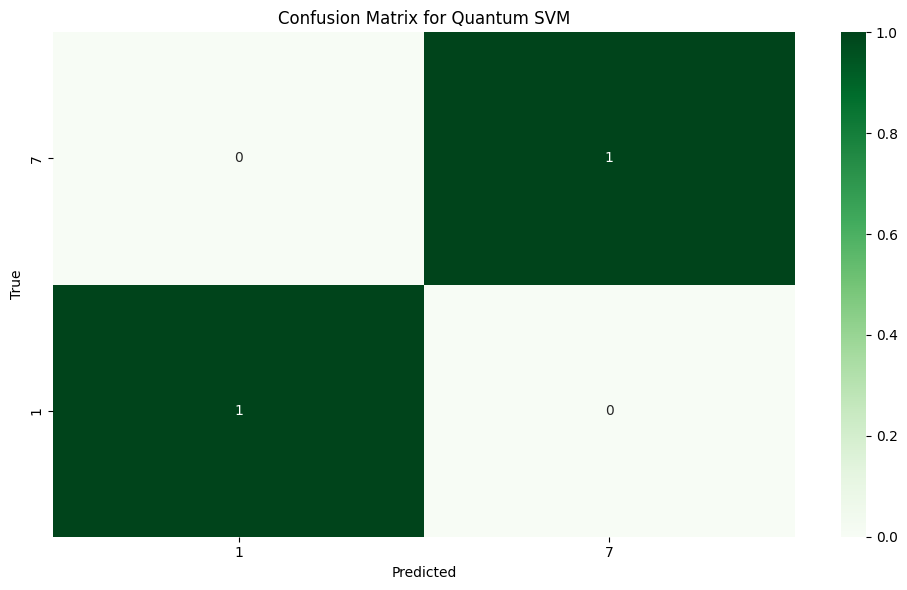

In [ ]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_q, normalize='true'),annot=True,cmap='Greens')
# add lables to show what is what
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Quantum SVM")
plt.xticks(ticks=[0.5, 1.5], labels=["1", "7"])
plt.yticks(ticks=[0.5, 1.5], labels=["1", "7"])
plt.gca().invert_yaxis()  # Invert y-axis to match the usual confusion matrix orientation
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show() 
#

### Real Backend

In [ ]:
n = 2
theta = ParameterVector('θ', 4)
alpha = 0.2

def build_feature_map():
    qc = QuantumCircuit(n)
    # RY rotations
    qc.ry(theta[0] * alpha, 0)
    qc.ry(theta[1] * alpha, 1)
    qc.cx(0, 1)

    # RX rotations
    qc.rx(theta[2] * alpha, 0)
    qc.rx(theta[3] * alpha, 1)
    qc.cx(0, 1)
    return qc

feature_map = build_feature_map()

In [ ]:
def quantum_kernel(x, y, sampler, n):
    
    # Compute the kernel value
    
    kernel_circuit = QuantumCircuit(n)

    bound_circuit = feature_map.assign_parameters(x[:X.shape[1]])
    uncompute_circuit = feature_map.inverse().assign_parameters(y[:X.shape[1]])
    
    kernel_circuit.append(bound_circuit.to_instruction(), [i for i in range(n)])
    kernel_circuit.append(uncompute_circuit.to_instruction(), [i for i in range(n)])
    kernel_circuit.measure_all()

    pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=1)
    isa_qc = pm.run(kernel_circuit)
    result = sampler.run([isa_qc], shots=256).result()
    pub_result = result[0]
    counts = pub_result.data.meas.get_counts()
    return counts['0'*n]/1024


In [ ]:
token = "44db434015550820982128b1408d2e7885f45187c79845a6887f1a9d3d78fd70f3ee55c5f7ca1ce1b4c656955418c7d56de67111afc4f0e884dac053b904798e"

service = QiskitRuntimeService(channel="ibm_quantum", token=token)

print("Available backends:", service.backends())

backend = service.backend('ibm_brisbane')

Available backends: [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>]


In [42]:
"""
with Session(backend=backend) as session:
    # Create an empty matrix to store the kernel values
    K_q = np.zeros((len(X_train), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_train)):
        print(i, "/", len(X_train))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_q[i, j] = quantum_kernel(X_train.iloc[i], X_train.iloc[j], sampler, n=2)
            except:
                K_q[i, j] = 0

"""
# Print the kernel matrix
#print(K_q)

'\nwith Session(backend=backend) as session:\n    # Create an empty matrix to store the kernel values\n    K_q = np.zeros((len(X_train), len(X_train)))\n\n    sampler = Sampler(mode=session)\n    # Loop over the rows of mnist_df\n    for i in range(len(X_train)):\n        print(i, "/", len(X_train))\n        # Loop over the columns of mnist_df\n        for j in range(len(X_train)):\n            # Compute the kernel value for each pair of data points\n            try:\n                K_q[i, j] = quantum_kernel(X_train.iloc[i], X_train.iloc[j], sampler, n=2)\n            except:\n                K_q[i, j] = 0\n\n'

Had to stop if after 2 hours after checking that in the IBM page it was not loading my tasks.   
qiskit_runtime_service.check_pending_jobs:WARNING:2025-05-03 10:40:36,136: The pending jobs limit has been reached. Waiting for job <RuntimeJobV2('d0ax334qnmvg0087974g', 'sampler')> to finish before submitting the next one.
27 / 80

In [ ]:
# Plot the kernel matrix as a heatmap
"""
plt.imshow(K_q, cmap="Blues")
plt.title("Quantum Kernel")
plt.colorbar()
plt.show()
"""

'\nplt.imshow(K_q, cmap="Blues")\nplt.title("Quantum Kernel")\nplt.colorbar()\nplt.show()\n'

In [ ]:
"""
clf = SVC(gamma='auto', kernel='precomputed')
clf.fit(K_q, y_train)
"""

"\nclf = SVC(gamma='auto', kernel='precomputed')\nclf.fit(K_q, y_train)\n"

In [43]:
"""
with Session(backend=backend) as session:
    # Create an empty matrix to store the kernel values
    K_test = np.zeros((len(X_test), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_test)):
        print(i, "/", len(X_test))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_test[i, j] = quantum_kernel(X_test.iloc[i], X_train.iloc[j], sampler, n=2)
            except:
                K_test[i, j] = 0
"""

'\nwith Session(backend=backend) as session:\n    # Create an empty matrix to store the kernel values\n    K_test = np.zeros((len(X_test), len(X_train)))\n\n    sampler = Sampler(mode=session)\n    # Loop over the rows of mnist_df\n    for i in range(len(X_test)):\n        print(i, "/", len(X_test))\n        # Loop over the columns of mnist_df\n        for j in range(len(X_train)):\n            # Compute the kernel value for each pair of data points\n            try:\n                K_test[i, j] = quantum_kernel(X_test.iloc[i], X_train.iloc[j], sampler, n=2)\n            except:\n                K_test[i, j] = 0\n'

In [ ]:
"""
# Plot the kernel matrix as a heatmap
plt.imshow(K_test, cmap="Blues")
plt.title("Quantum Kernel test")
plt.colorbar()
plt.show()
"""

In [ ]:
"""
y_pred_q = clf.predict(K_test)
# Calculate accuracy
accuracy_q = accuracy_score(y_test, y_pred_q)
print('Accuracy:', accuracy_q)
"""

"\ny_pred_q = clf.predict(K_test)\n# Calculate accuracy\naccuracy_q = accuracy_score(y_test, y_pred_q)\nprint('Accuracy:', accuracy_q)\n"

In [ ]:
#accuracy_score(y_pred, y_pred_q)

In [ ]:
#print(classification_report(y_test, y_pred_q))

In [ ]:
"""
ax = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_q, normalize='true'),annot=True,cmap='Blues')
# add lables to show what is what
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Quantum SVM")
plt.xticks(ticks=[0.5, 1.5], labels=["1", "7"])
plt.yticks(ticks=[0.5, 1.5], labels=["1", "7"])
plt.gca().invert_yaxis()  # Invert y-axis to match the usual confusion matrix orientation
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show() 
"""

'\nax = plt.figure(figsize=(10, 6))\nsns.heatmap(confusion_matrix(y_test, y_pred_q, normalize=\'true\'),annot=True,cmap=\'Blues\')\n# add lables to show what is what\nplt.xlabel("Predicted")\nplt.ylabel("True")\nplt.title("Confusion Matrix for Quantum SVM")\nplt.xticks(ticks=[0.5, 1.5], labels=["1", "7"])\nplt.yticks(ticks=[0.5, 1.5], labels=["1", "7"])\nplt.gca().invert_yaxis()  # Invert y-axis to match the usual confusion matrix orientation\nplt.tight_layout()  # Adjust layout to prevent clipping of tick-labels\nplt.show() \n'

### More than 2 numbers classificator (1,2,3,4)


In [3]:
# 1. Load MNIST
mnist = fetch_openml('mnist_784', version=1, as_frame=True)
mnist_df = mnist.frame               # DataFrame with pixels + “class” column
y = mnist_df['class'].astype(int)    # target
X = (mnist_df
    .drop(columns='class')
    .gt(230)                # pixel > 230 become True, else False
    .astype(np.int8))       # True → 1, False → 0   normalize pixel values to 0 and 1

# 2. Preprocess the data
# Need to just take 1's, 2's, 3's, 4's from the dataset
mask = (y == 1) | (y == 2) | (y == 3) | (y == 4)
X_ds = X[mask]
y_ds = y[mask]

# Reduce to 8 principal components
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_ds)

# Display the variance explained by each component
print(f"Variance explained by component: {pca.explained_variance_ratio_}")

# Split the dataset into training and testing sets
X_train_big, X_test_big, y_train_big, y_test_big = train_test_split(X_pca, y_ds, test_size=0.2, random_state=0)

# Smaller subset for training and testing
# For train subset:
X_train, _, y_train, _ = train_test_split(
    X_train_big, y_train_big,
    train_size=80,
    random_state=0,
    shuffle=True
)
# For test subset:
X_test, _, y_test, _ = train_test_split(
    X_test_big, y_test_big,
    train_size=20,
    random_state=0,
    shuffle=True
)

# Reset index of the training and testing sets
X_train = pd.DataFrame(X_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

# Scale features to the range [0, 2*pi] - fit on training set only
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Display the first 5 rows of the filtered data
print(X_train.head())

# Print the shapes of the subsets
print(f"Subset shapes: X_train_subset: {X_train.shape}, y_train_subset: {y_train.shape}")
print(f"Subset shapes: X_test_subset: {X_test.shape}, y_test_subset: {y_test.shape}")


Variance explained by component: [0.08019729 0.07105188 0.05475355 0.03931693]
          0         1         2         3
0  0.346811  1.593093  3.071394  4.940330
1  3.893491  4.794160  1.203791  1.867230
2  0.078284  2.249672  4.545421  3.359353
3  1.972650  3.913548  1.008266  1.797597
4  4.501159  4.477302  3.697641  5.394190
Subset shapes: X_train_subset: (80, 4), y_train_subset: (80,)
Subset shapes: X_test_subset: (20, 4), y_test_subset: (20,)


#### Visualization of the "new" dataset

chosen the first 2 variables of the PCA

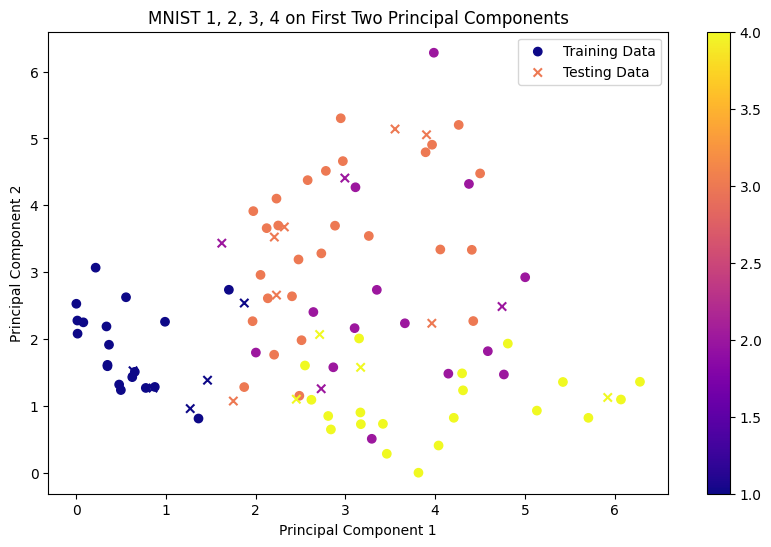

In [9]:
# 3. Visualize the data
plt.figure(figsize=(10, 6))

# Training data (PC1 vs PC2)
plt.scatter(
    X_train[0], X_train[1],
    c=y_train,
    cmap='plasma',
    marker='o',
    label='Training Data'
)

# Testing data (PC1 vs PC2)
plt.scatter(
    X_test[0], X_test[1],
    c=y_test,
    cmap='plasma',
    marker='x',
    label='Testing Data'
)

# Labels, colorbar and legend
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
cbar = plt.colorbar()
plt.legend()
plt.title("MNIST 1, 2, 3, 4 on First Two Principal Components")
plt.show()


### Classical SVM


In [10]:
#RBF SVM
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf_rbf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.9


In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         4
           3       0.86      0.86      0.86         7
           4       0.80      1.00      0.89         4

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.91        20
weighted avg       0.91      0.90      0.90        20



([<matplotlib.axis.YTick at 0x1c77ff355e0>,
 [Text(0, 0, '1'), Text(0, 1, '2'), Text(0, 2, '3'), Text(0, 3, '4')])

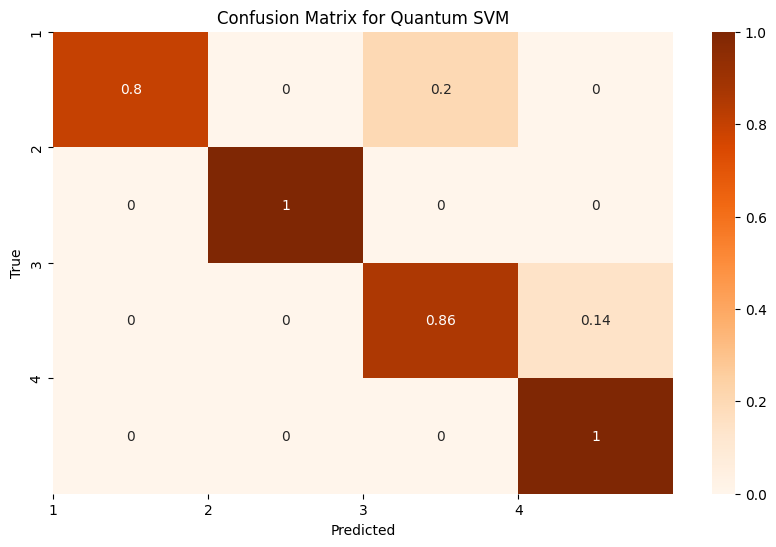

In [8]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'),annot=True,cmap='Oranges')
# add lables to show what is what
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Classical SVM")
plt.xticks(ticks=np.arange(4), labels=["1", "2", "3", "4"])
plt.yticks(ticks=np.arange(4), labels=["1", "2", "3", "4"])


### Quantum Kernel

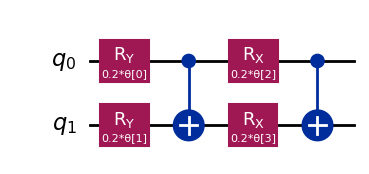

In [12]:
n = 2
thetas = ParameterVector('θ',X_train.shape[1])
alpha = 0.2

qc = QuantumCircuit(n)

qc.ry(thetas[0] * alpha, 0)
qc.ry(thetas[1] * alpha, 1)

for i in range(n-1):
    qc.cx(i, i+1)

qc.rx(thetas[2] * alpha, 0)
qc.rx(thetas[3] * alpha, 1)

for i in range(n-1):
    qc.cx(i, i+1)


qc.draw('mpl')

In [13]:
def quantum_kernel(x, y, sampler, n):

    # Compute the kernel value
    
    kernel_circuit = QuantumCircuit(n)

    bound_circuit = qc.assign_parameters(x[:X.shape[1]])
    uncompute_circuit = qc.inverse().assign_parameters(y[:X.shape[1]])
    
    kernel_circuit.append(bound_circuit.to_instruction(), [i for i in range(n)])
    kernel_circuit.append(uncompute_circuit.to_instruction(), [i for i in range(n)])
    kernel_circuit.measure_all()

    pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=1)
    isa_qc = pm.run(kernel_circuit)
    result = sampler.run([isa_qc]).result()
    pub_result = result[0]
    counts = pub_result.data.meas.get_counts()
    return counts['0'*n]/1024




In [ ]:
aer_sim = AerSimulator()
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_q = np.zeros((len(X_train), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_train)):
        print(i, "/", len(X_train))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_q[i, j] = quantum_kernel(X_train.iloc[i], X_train.iloc[j], sampler, n=2)
            except:
                K_q[i, j] = 0

# Print the kernel matrix
print(K_q)

0 / 80
1 / 80
2 / 80
3 / 80
4 / 80
5 / 80
6 / 80
7 / 80
8 / 80
9 / 80
10 / 80
11 / 80
12 / 80
13 / 80
14 / 80
15 / 80
16 / 80
17 / 80
18 / 80
19 / 80
20 / 80
21 / 80
22 / 80
23 / 80
24 / 80
25 / 80
26 / 80
27 / 80
28 / 80
29 / 80
30 / 80
31 / 80
32 / 80
33 / 80
34 / 80
35 / 80
36 / 80
37 / 80
38 / 80
39 / 80
40 / 80
41 / 80
42 / 80
43 / 80
44 / 80
45 / 80
46 / 80
47 / 80
48 / 80
49 / 80
50 / 80
51 / 80
52 / 80
53 / 80
54 / 80
55 / 80
56 / 80
57 / 80
58 / 80
59 / 80
60 / 80
61 / 80
62 / 80
63 / 80
64 / 80
65 / 80
66 / 80
67 / 80
68 / 80
69 / 80
70 / 80
71 / 80
72 / 80
73 / 80
74 / 80
75 / 80
76 / 80
77 / 80
78 / 80
79 / 80
[[1.         0.71875    0.95703125 ... 0.921875   0.69335938 0.57421875]
 [0.68554688 1.         0.71386719 ... 0.81933594 0.75390625 0.83984375]
 [0.9609375  0.68066406 1.         ... 0.89550781 0.640625   0.58886719]
 ...
 [0.8984375  0.84863281 0.88085938 ... 1.         0.82519531 0.82519531]
 [0.70605469 0.74902344 0.65429688 ... 0.828125   1.         0.95117188]


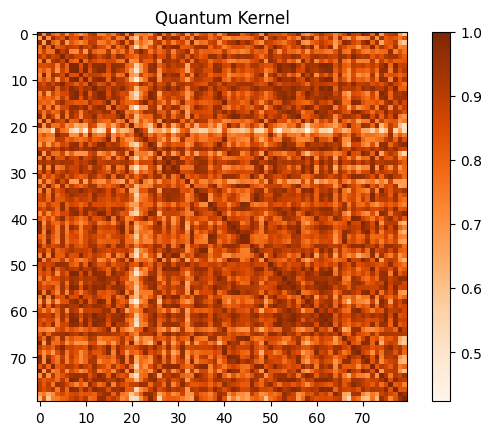

In [ ]:
# Plot the kernel matrix as a heatmap
plt.imshow(K_q, cmap="Oranges")
plt.title("Quantum Kernel")
plt.colorbar()
plt.show()

In [ ]:
clf = SVC(gamma='auto', kernel='precomputed')
clf.fit(K_q, y_train)

SVC(gamma='auto', kernel='precomputed')

In [ ]:
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_test = np.zeros((len(X_test), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_test)):
        print(i, "/", len(X_test))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_test[i, j] = quantum_kernel(X_test.iloc[i], X_train.iloc[j], sampler, n=2)
            except:
                K_test[i, j] = 0


0 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20


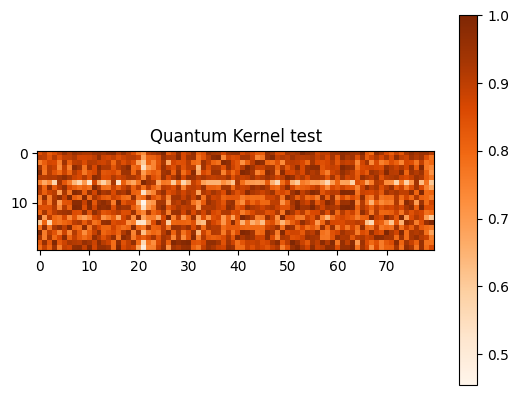

In [ ]:
# Plot the kernel matrix as a heatmap
plt.imshow(K_test, cmap="Oranges")
plt.title("Quantum Kernel test")
plt.colorbar()
plt.show()

In [ ]:
y_pred_q = clf.predict(K_test)
# Calculate accuracy
accuracy_q = accuracy_score(y_test, y_pred_q)
print('Accuracy:', accuracy_q)

Accuracy: 0.7


In [ ]:
accuracy_score(y_pred, y_pred_q)

0.3

In [ ]:
print(classification_report(y_test, y_pred_q))

              precision    recall  f1-score   support

           1       0.71      1.00      0.83         5
           2       1.00      0.25      0.40         4
           3       0.71      0.71      0.71         7
           4       0.60      0.75      0.67         4

    accuracy                           0.70        20
   macro avg       0.76      0.68      0.65        20
weighted avg       0.75      0.70      0.67        20



([<matplotlib.axis.YTick at 0x23b7e48ef90>,
 [Text(0, 0, '1'), Text(0, 1, '2'), Text(0, 2, '3'), Text(0, 3, '4')])

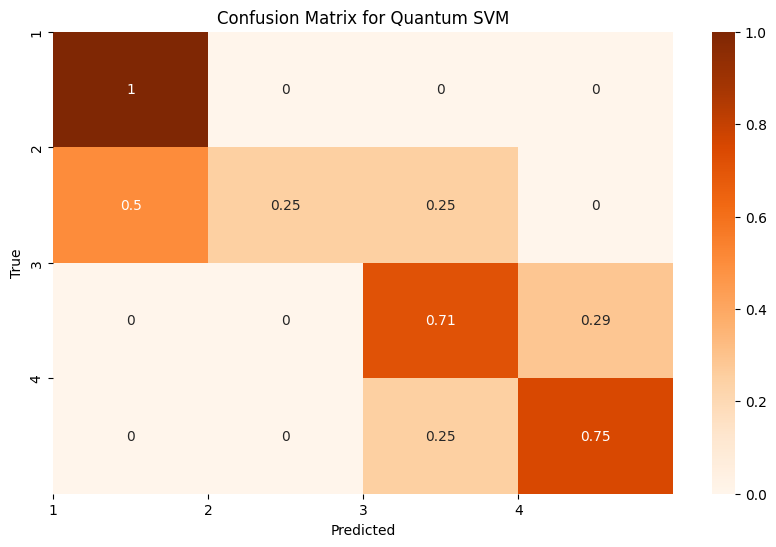

In [ ]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_q, normalize='true'),annot=True,cmap='Oranges')
# add lables to show what is what
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Quantum SVM")
plt.xticks(ticks=np.arange(4), labels=["1", "2", "3", "4"])
plt.yticks(ticks=np.arange(4), labels=["1", "2", "3", "4"])


### Second Iteration: Feature Map from library

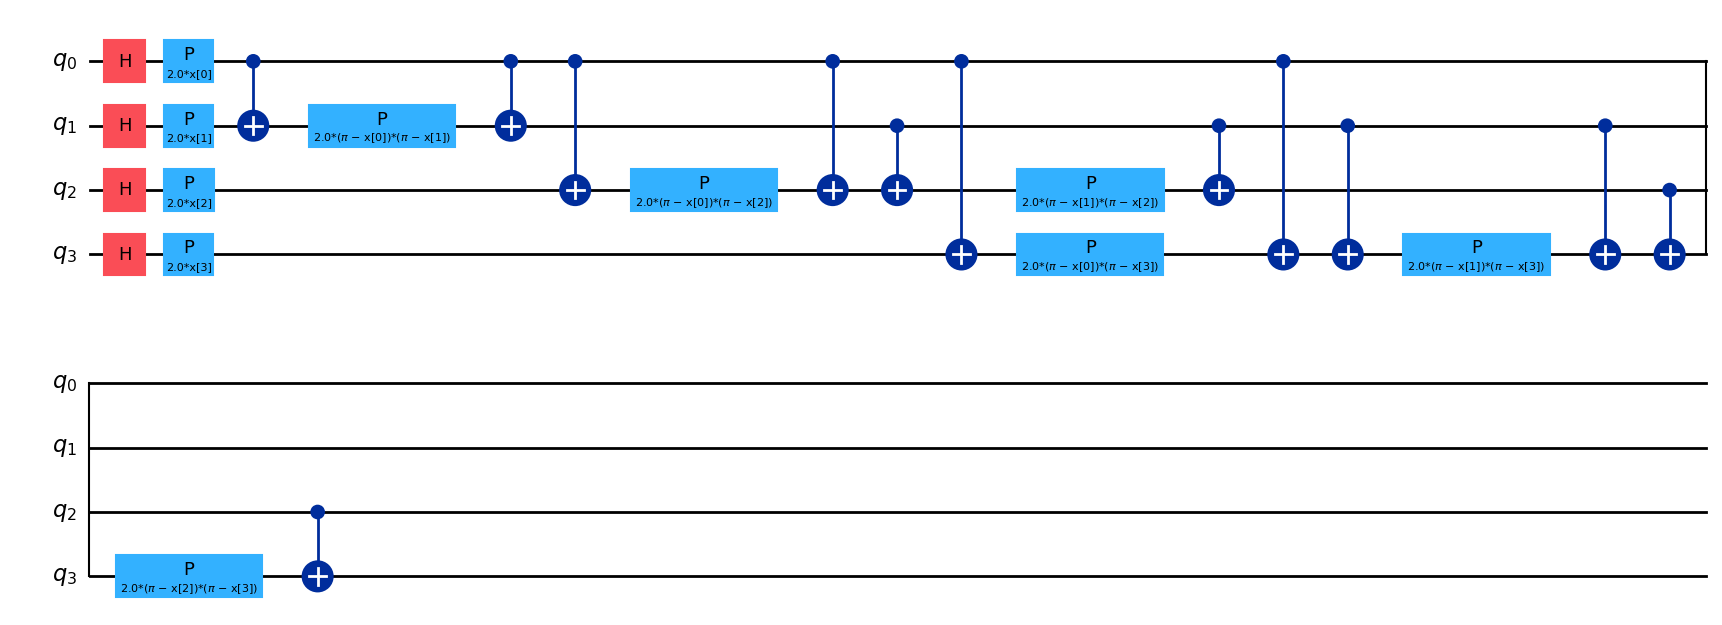

In [28]:
import numpy as np
from qiskit.circuit.library import PauliFeatureMap

n = 4
feature_map = PauliFeatureMap(
    feature_dimension=n,
    reps=1,                
    paulis=['Z', 'ZZ'],    # single- and two-qubit terms
    entanglement='full'     # every qubit entangled with every other
)

display(feature_map.decompose().draw('mpl'))


In [29]:
def quantum_kernel(x, y, sampler, n):

    # Compute the kernel value
    
    kernel_circuit = QuantumCircuit(n)

    bound_circuit = feature_map.assign_parameters(x[:X.shape[1]])
    uncompute_circuit = feature_map.inverse().assign_parameters(y[:X.shape[1]])
    
    kernel_circuit.append(bound_circuit.to_instruction(), [i for i in range(n)])
    kernel_circuit.append(uncompute_circuit.to_instruction(), [i for i in range(n)])
    kernel_circuit.measure_all()

    pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=1)
    isa_qc = pm.run(kernel_circuit)
    result = sampler.run([isa_qc]).result()
    pub_result = result[0]
    counts = pub_result.data.meas.get_counts()
    return counts['0'*n]/1024


In [ ]:
aer_sim = AerSimulator()
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_q = np.zeros((len(X_train), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_train)):
        print(i, "/", len(X_train))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_q[i, j] = quantum_kernel(X_train.iloc[i], X_train.iloc[j], sampler, n=4)
            except:
                K_q[i, j] = 0

# Print the kernel matrix
print(K_q)

0 / 80
1 / 80
2 / 80
3 / 80
4 / 80
5 / 80
6 / 80
7 / 80
8 / 80
9 / 80
10 / 80
11 / 80
12 / 80
13 / 80
14 / 80
15 / 80
16 / 80
17 / 80
18 / 80
19 / 80
20 / 80
21 / 80
22 / 80
23 / 80
24 / 80
25 / 80
26 / 80
27 / 80
28 / 80
29 / 80
30 / 80
31 / 80
32 / 80
33 / 80
34 / 80
35 / 80
36 / 80
37 / 80
38 / 80
39 / 80
40 / 80
41 / 80
42 / 80
43 / 80
44 / 80
45 / 80
46 / 80
47 / 80
48 / 80
49 / 80
50 / 80
51 / 80
52 / 80
53 / 80
54 / 80
55 / 80
56 / 80
57 / 80
58 / 80
59 / 80
60 / 80
61 / 80
62 / 80
63 / 80
64 / 80
65 / 80
66 / 80
67 / 80
68 / 80
69 / 80
70 / 80
71 / 80
72 / 80
73 / 80
74 / 80
75 / 80
76 / 80
77 / 80
78 / 80
79 / 80
[[1.00000000e+00 1.95312500e-03 2.53906250e-02 ... 6.44531250e-02
  1.77734375e-01 9.17968750e-02]
 [9.76562500e-04 1.00000000e+00 1.36718750e-02 ... 4.88281250e-03
  5.85937500e-02 2.05078125e-02]
 [1.95312500e-02 9.76562500e-04 1.00000000e+00 ... 7.81250000e-02
  9.76562500e-03 1.44531250e-01]
 ...
 [7.71484375e-02 6.83593750e-03 7.42187500e-02 ... 1.00000000e+00
  

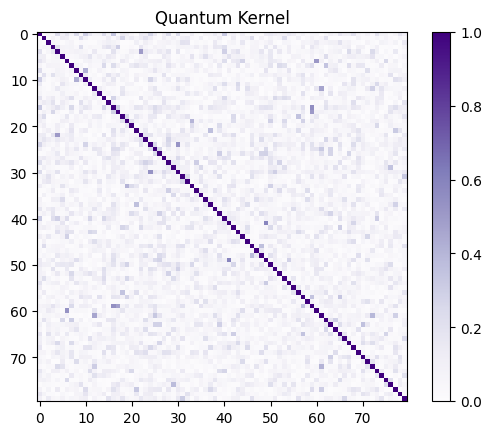

In [31]:
# Plot the kernel matrix as a heatmap
plt.imshow(K_q, cmap="Purples")
plt.title("Quantum Kernel")
plt.colorbar()
plt.show()

In [32]:
clf = SVC(gamma='auto', kernel='precomputed')
clf.fit(K_q, y_train)

SVC(gamma='auto', kernel='precomputed')

In [35]:
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_test = np.zeros((len(X_test), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of mnist_df
    for i in range(len(X_test)):
        print(i, "/", len(X_test))
        # Loop over the columns of mnist_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_test[i, j] = quantum_kernel(X_test.iloc[i], X_train.iloc[j], sampler, n=4)
            except:
                K_test[i, j] = 0


0 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20


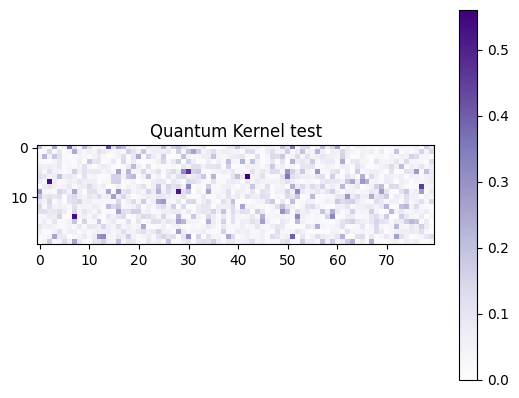

In [36]:
# Plot the kernel matrix as a heatmap
plt.imshow(K_test, cmap="Purples")
plt.title("Quantum Kernel test")
plt.colorbar()
plt.show()

In [37]:
y_pred_q = clf.predict(K_test)
# Calculate accuracy
accuracy_q = accuracy_score(y_test, y_pred_q)
print('Accuracy:', accuracy_q)

Accuracy: 0.5


In [38]:
accuracy_score(y_pred, y_pred_q)

0.5

In [39]:
print(classification_report(y_test, y_pred_q))

              precision    recall  f1-score   support

           1       0.25      0.20      0.22         5
           2       0.00      0.00      0.00         4
           3       0.50      1.00      0.67         7
           4       1.00      0.50      0.67         4

    accuracy                           0.50        20
   macro avg       0.44      0.42      0.39        20
weighted avg       0.44      0.50      0.42        20



c:\Users\juanf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\juanf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\juanf\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

([<matplotlib.axis.YTick at 0x1c7d8943080>,
 [Text(0, 0, '1'), Text(0, 1, '2'), Text(0, 2, '3'), Text(0, 3, '4')])

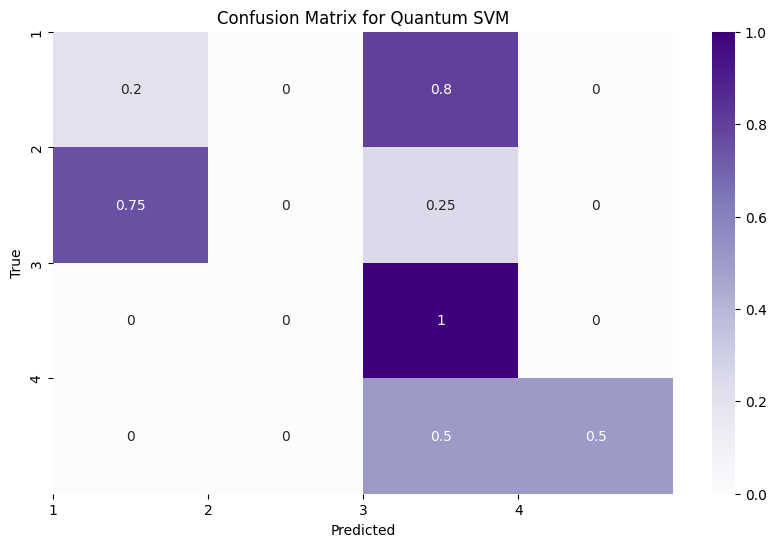

In [40]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_q, normalize='true'),annot=True,cmap='Purples')
# add lables to show what is what
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Quantum SVM")
plt.xticks(ticks=np.arange(4), labels=["1", "2", "3", "4"])
plt.yticks(ticks=np.arange(4), labels=["1", "2", "3", "4"])
